# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
import gym
import random
import torch
import time

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from ddpg_agent_main import Agent

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.13999999687075615


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
agent = Agent(state_size=state_size, 
              action_size=action_size,
              random_seed=42)

In [9]:
def ddpg(n_episodes=1500, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=print_every)
    scores = []
    stability = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        agent.reset()
        score = np.zeros(num_agents)
        st_time = time.time()
        
        update = False
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            update = True if t%20 == 0 else False              # update only every 20th timestamp
            
            agent.step(states, actions, rewards, next_states, dones, update)
            states = next_states
            score += rewards
            if any(dones):
                break 
                     
        epi_score = np.mean(score)
        scores_deque.append(epi_score)
        scores.append(epi_score)
        overall_score = np.mean(scores_deque)
        
        episode_time = time.time() - st_time
        
        print('\rEpisode {}\tEpisode Average Score: {:.2f}\tOverall Average Score: {:.2f}\tEpisode Time: {:.2f}s'
              .format(i_episode, epi_score, overall_score, episode_time), end="")
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tEpisode Average Score: {:.2f}\tOverall Average Score: {:.2f}'
                  .format(i_episode, epi_score, overall_score))
        
        if overall_score >= 30:
            stability += 1
            
        if stability >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(i_episode, overall_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

scores = ddpg()

Episode 10	Episode Average Score: 0.02	Overall Average Score: 0.30	Episode Time: 24.53s
Episode 20	Episode Average Score: 0.09	Overall Average Score: 0.05	Episode Time: 31.46s
Episode 30	Episode Average Score: 1.93	Overall Average Score: 0.82	Episode Time: 41.53s
Episode 40	Episode Average Score: 3.31	Overall Average Score: 2.35	Episode Time: 51.64s
Episode 50	Episode Average Score: 7.83	Overall Average Score: 6.28	Episode Time: 61.16s
Episode 60	Episode Average Score: 13.74	Overall Average Score: 10.76	Episode Time: 62.08s
Episode 70	Episode Average Score: 17.15	Overall Average Score: 16.10	Episode Time: 62.42s
Episode 80	Episode Average Score: 21.00	Overall Average Score: 19.65	Episode Time: 62.21s
Episode 90	Episode Average Score: 27.23	Overall Average Score: 23.79	Episode Time: 62.51s
Episode 100	Episode Average Score: 30.58	Overall Average Score: 29.10	Episode Time: 62.59s
Episode 110	Episode Average Score: 36.98	Overall Average Score: 35.16	Episode Time: 62.71s
Episode 120	Episod

### Initial Attempts:  
-  In the first few attempts on both (single and 20 agents) environments, there was no significant improvement visible from the graphs.
-  In the later attempts, following parameters were adjusted:  
    - Batch size increased to 1024.
    - Gradient Clipping added to the update of Critic network -> Significant improvement observed from the graph and the average score of 30 was achieved in the 29th episode but the execution terminated at this point (as the condition was missing to execute till 100 episodes).

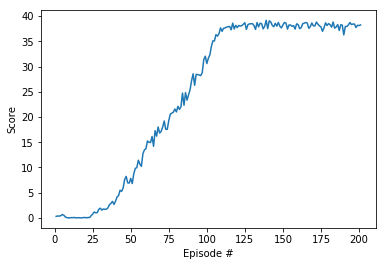

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Final Attempt Results  
The Average score of 30 was achieved at episode: 101. Afterwards, it remained stable and above the mark for the next 100 episodes. 

### Final Total Score

In [11]:
# Load the saved weights into Pytorch model
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

while True:
    actions = agent.act(states)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score: {}'.format(np.mean(scores)))

Total score: 38.45199914053082


In [12]:
env.close()